In [1]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def quaternion_angle_error(q1, q2):
    """
    Computes the angle (in degrees) between two quaternions.
    Assumes q = [w, x, y, z].
    """
    # Dot product
    dot = np.abs(np.dot(q1, q2))
    # Clamp to handle numerical errors
    dot = np.clip(dot, -1.0, 1.0)
    # Angle formula: 2 * arccos(|<q1, q2>|)
    return 2 * np.arccos(dot) * (180 / np.pi)

In [3]:
data = []

# Update with your actual path
with h5py.File("../dataset.h5", "r") as f:
    primitives = f.attrs["primitives"]  # Expecting string list

    for scene_id in f.keys():
        dp = f[scene_id]
        # Depending on h5 structure, ensure these exist
        if "poses" not in dp:
            continue

        num_objects = len(dp["poses"])
        for oi in range(num_objects):
            # Extract raw data
            object_pose = dp["poses"][oi]  # 7D: [x,y,z, qw,qx,qy,qz]
            object_size = dp["sizes"][oi]  # 3D: [w, d, h]
            target_pose = dp["target_poses"][oi]  # 7D

            for pi, primitive in enumerate(primitives):
                # NOTE: Check if your primitive strings are bytes or strings
                if isinstance(primitive, bytes):
                    primitive = primitive.decode("utf-8")

                primitive_parts = primitive.split("_")

                # Check kinematic feasibility
                is_feasible = bool(dp["feasibles"][oi][pi])

                # Extract execution result
                final_pose = dp["final_poses"][oi][pi]

                # --- NEW METRICS CALCULATION ---
                # Position Error (Euclidean distance)
                # Poses are [x, y, z, qw, qx, qy, qz] -> indices 0,1,2 for pos
                pos_err = np.linalg.norm(target_pose[:3] - final_pose[:3])

                # Rotation Error (Quaternion angle)
                # Indices 3,4,5,6 for quaternion [w, x, y, z]
                q_target = target_pose[3:]
                q_final = final_pose[3:]
                rot_err = quaternion_angle_error(q_target, q_final)

                data.append(
                    {
                        "scene_id": scene_id,
                        "object_id": oi,
                        "primitive": primitive,
                        "primitive_type": primitive_parts[0],
                        "primitive_axis": primitive_parts[1],
                        "feasible": is_feasible,
                        "object_volume": np.prod(object_size),
                        "object_height": object_size[2],
                        "pos_error": pos_err,
                        "rot_error": rot_err,
                    }
                )

df = pd.DataFrame(data)
print(f"Loaded {len(df)} attempts.")

df_feasible = df[df["feasible"]].copy()

Loaded 397552 attempts.


In [23]:
lifts = df_feasible[df_feasible["primitive_type"] == "lift"]
pulls = df_feasible[df_feasible["primitive_type"] == "push"]
pushes = df_feasible[df_feasible["primitive_type"] == "push"]

# Set style for professional plots
sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 12, "font.family": "sans-serif"})

In [25]:
def get_binned_stats(df, x_col, y_col, bins=6, shared_bins=None):
    """
    Helper to bin data and calculate Mean + 95% CI.
    Allows passing 'shared_bins' (a list/array of edges) to ensure
    multiple datasets use the exact same x-axis buckets.
    """
    df_subset = df.copy()

    # Use specific bin edges if provided, otherwise auto-calculate
    bin_arg = shared_bins if shared_bins is not None else bins
    df_subset["bin"] = pd.cut(df_subset[x_col], bins=bin_arg)

    # Aggregate
    stats = df_subset.groupby("bin", observed=False)[y_col].agg(["mean", "count", "std"]).reset_index()

    # Calculate 95% Confidence Interval
    # Handle NaN cases (if a bin has 0 or 1 item)
    stats = stats[stats["count"] > 1]
    stats["ci"] = 1.96 * (stats["std"] / np.sqrt(stats["count"]))
    stats["mid"] = stats["bin"].apply(lambda x: x.mid)

    return stats

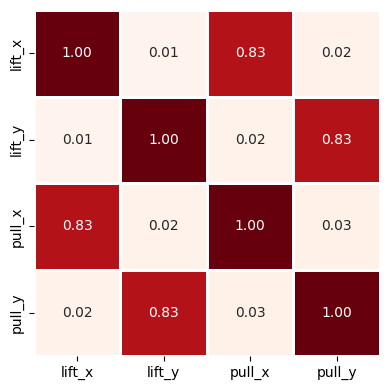

In [4]:
target_prims = ["lift_x", "lift_y", "pull_x", "pull_y"]
df_subset = df[df["primitive"].isin(target_prims)]

feas_matrix = df_subset.pivot_table(index=["scene_id", "object_id"], columns="primitive", values="feasible", aggfunc="max")

corr = feas_matrix.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap="Reds", vmin=0, vmax=1, fmt=".2f", square=True, cbar=False, linewidths=1, linecolor="white")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.savefig("lift_pull_corr.pdf", transparent=True)
plt.show()

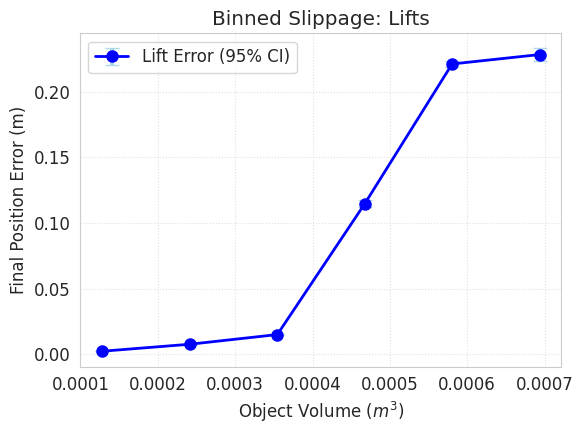

In [26]:
lift_stats = get_binned_stats(lifts, "object_volume", "pos_error", bins=6)

plt.figure(figsize=(6, 4.5))
plt.errorbar(
    lift_stats["mid"],
    lift_stats["mean"],
    yerr=lift_stats["ci"],
    fmt="-o",
    color="blue",
    ecolor="lightblue",
    elinewidth=3,
    capsize=5,
    linewidth=2,
    markersize=8,
    label="Lift Error (95% CI)",
)

plt.xlabel("Object Volume ($m^3$)", fontsize=12)
plt.ylabel("Final Position Error (m)", fontsize=12)
plt.title("Binned Slippage: Lifts")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

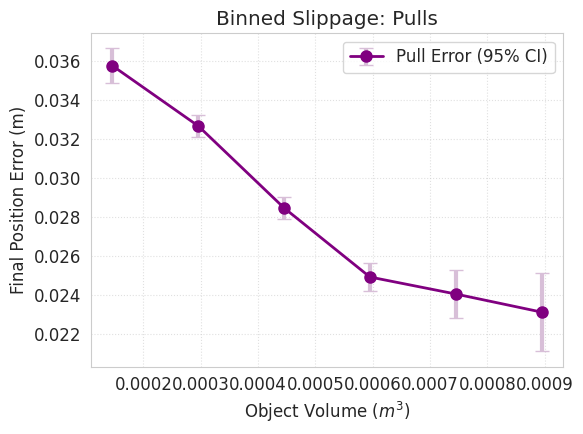

In [27]:
pull_stats = get_binned_stats(pulls, "object_volume", "pos_error", bins=6)

plt.figure(figsize=(6, 4.5))
plt.errorbar(
    pull_stats["mid"],
    pull_stats["mean"],
    yerr=pull_stats["ci"],
    fmt="-o",
    color="purple",
    ecolor="thistle",
    elinewidth=3,
    capsize=5,
    linewidth=2,
    markersize=8,
    label="Pull Error (95% CI)",
)

plt.xlabel("Object Volume ($m^3$)", fontsize=12)
plt.ylabel("Final Position Error (m)", fontsize=12)
plt.title("Binned Slippage: Pulls")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

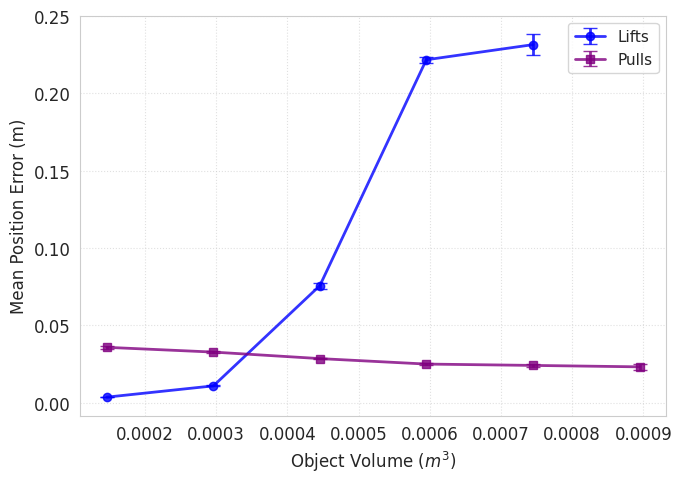

In [ ]:
all_volumes = pd.concat([lifts["object_volume"], pulls["object_volume"]])
shared_edges = np.linspace(all_volumes.min(), all_volumes.max(), 7)

lift_stats_shared = get_binned_stats(lifts, "object_volume", "pos_error", shared_bins=shared_edges)
pull_stats_shared = get_binned_stats(pulls, "object_volume", "pos_error", shared_bins=shared_edges)

plt.figure(figsize=(7, 5))

# Plot Lifts
plt.errorbar(
    lift_stats_shared["mid"],
    lift_stats_shared["mean"],
    yerr=lift_stats_shared["ci"],
    fmt="-o",
    color="blue",
    capsize=5,
    linewidth=2,
    label="Lifts",
    alpha=0.8,
)

plt.errorbar(
    pull_stats_shared["mid"],
    pull_stats_shared["mean"],
    yerr=pull_stats_shared["ci"],
    fmt="-s",
    color="purple",
    capsize=5,
    linewidth=2,
    label="Pulls",
    alpha=0.8,
)

plt.xlabel("Object Volume ($m^3$)", fontsize=12)
plt.ylabel("Mean Position Error (m)", fontsize=12)
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(fontsize=11)
plt.tight_layout()

plt.savefig("slippage_comparison_binned.pdf", dpi=300, bbox_inches="tight")
plt.show()

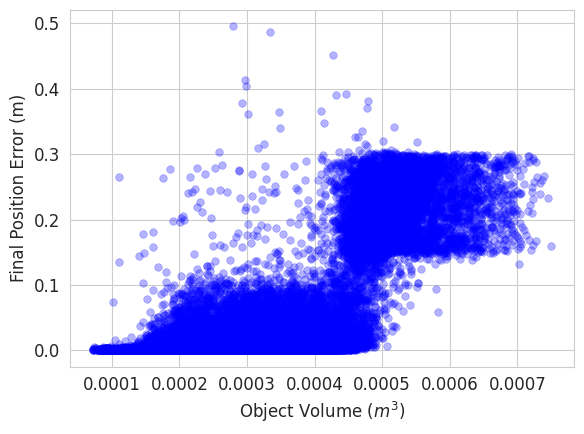

In [22]:
plt.figure(figsize=(6, 4.5))
sns.scatterplot(data=lifts, x="object_volume", y="pos_error", alpha=0.3, color="blue", edgecolor=None, s=30)

plt.xlabel("Object Volume ($m^3$)", fontsize=12)
plt.ylabel("Final Position Error (m)", fontsize=12)
plt.tight_layout()
plt.savefig("slippage.png", dpi=300, bbox_inches="tight")
plt.show()

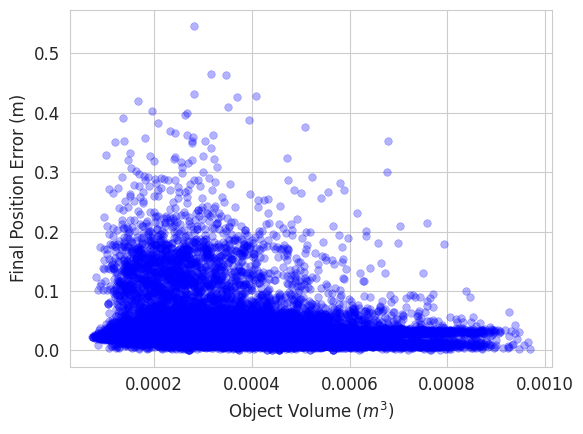

In [24]:
plt.figure(figsize=(6, 4.5))
sns.scatterplot(data=pulls, x="object_volume", y="pos_error", alpha=0.3, color="blue", edgecolor=None, s=30)

plt.xlabel("Object Volume ($m^3$)", fontsize=12)
plt.ylabel("Final Position Error (m)", fontsize=12)
plt.tight_layout()
plt.savefig("slippage.png", dpi=300, bbox_inches="tight")
plt.show()

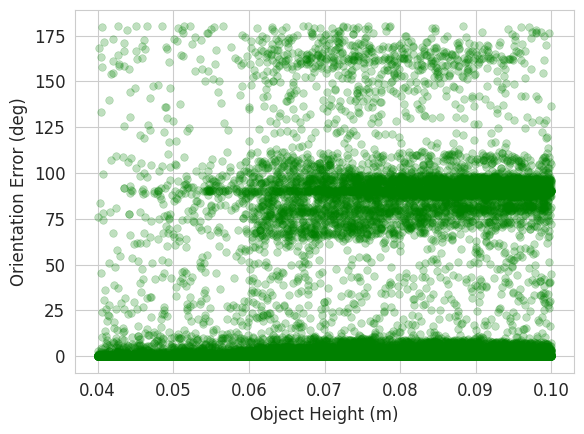

In [16]:
plt.figure(figsize=(6, 4.5))
sns.scatterplot(data=pushes, x="object_height", y="rot_error", alpha=0.25, color="green", edgecolor=None, s=30)

plt.xlabel("Object Height (m)", fontsize=12)
plt.ylabel("Orientation Error (deg)", fontsize=12)
plt.tight_layout()
plt.savefig("plot_2_push_tipping_raw.pdf", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_628409/1272530118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pushes["height_bin"] = pd.cut(pushes["object_height"], bins=6)


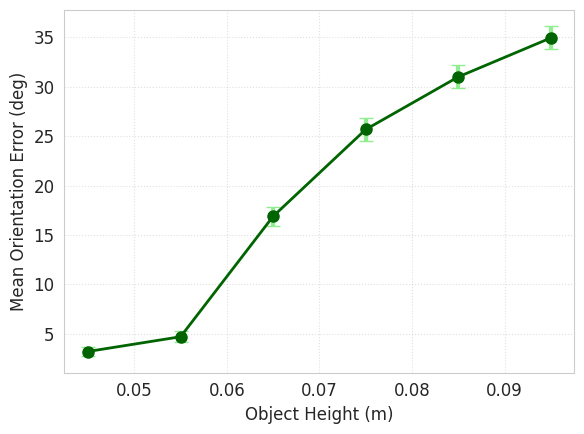

In [21]:
pushes["height_bin"] = pd.cut(pushes["object_height"], bins=6)

bin_stats = pushes.groupby("height_bin", observed=False)["rot_error"].agg(["mean", "count", "std"]).reset_index()

# Calculate Confidence Interval (95%)
# CI = 1.96 * (std / sqrt(n))
bin_stats["ci"] = 1.96 * (bin_stats["std"] / np.sqrt(bin_stats["count"]))
bin_stats["height_mid"] = bin_stats["height_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(6, 4.5))

plt.errorbar(
    bin_stats["height_mid"],
    bin_stats["mean"],
    yerr=bin_stats["ci"],
    fmt="-o",
    color="darkgreen",
    ecolor="lightgreen",
    elinewidth=3,
    capsize=5,
    linewidth=2,
    markersize=8,
    label="Mean Error (95% CI)",
)

plt.xlabel("Object Height (m)", fontsize=12)
plt.ylabel("Mean Orientation Error (deg)", fontsize=12)
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.savefig("plot_3_push_tipping_binned.pdf", dpi=300, bbox_inches="tight")
plt.show()

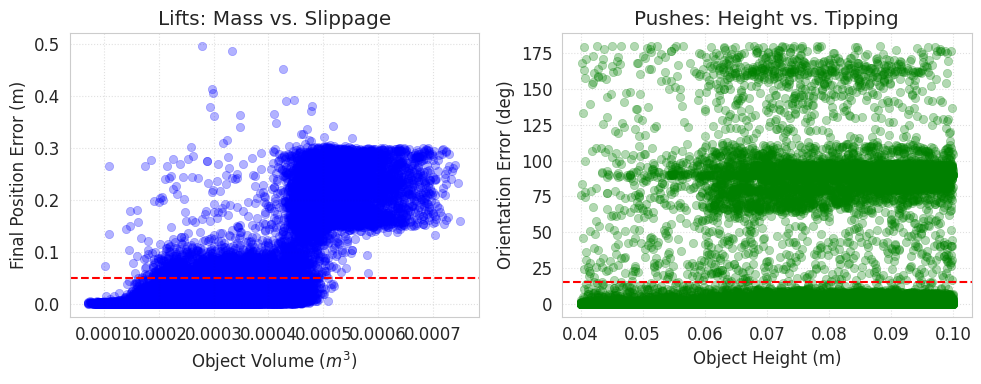

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

lifts = df_feasible[df_feasible["primitive_type"] == "lift"]

sns.scatterplot(data=lifts, x="object_volume", y="pos_error", alpha=0.3, color="blue", edgecolor=None, ax=ax1)

ax1.axhline(0.05, color="red", linestyle="--", label="Slip Threshold")
ax1.set_title("Lifts: Mass vs. Slippage")
ax1.set_xlabel("Object Volume ($m^3$)")
ax1.set_ylabel("Final Position Error (m)")
ax1.grid(True, linestyle=":", alpha=0.6)

# --- PLOT 2: PUSHES & TIPPING ---
# Filter: Pushes that were kinematically feasible
pushes = df_feasible[df_feasible["primitive_type"] == "push"]

sns.scatterplot(data=pushes, x="object_height", y="rot_error", alpha=0.3, color="green", edgecolor=None, ax=ax2)

# Assuming angle error > 15 degrees is a "tip"
ax2.axhline(15, color="red", linestyle="--", label="Tip Threshold")
ax2.set_title("Pushes: Height vs. Tipping")
ax2.set_xlabel("Object Height (m)")
ax2.set_ylabel("Orientation Error (deg)")
ax2.grid(True, linestyle=":", alpha=0.6)

plt.tight_layout()
plt.savefig("physics_failure_modes.pdf", transparent=True)
plt.show()

/tmp/ipykernel_628409/3533743700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pushes["height_bin"] = pd.cut(pushes["object_height"], bins=5)
/tmp/ipykernel_628409/3533743700.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = pushes.groupby("height_bin")["rot_error"].agg(["mean", "std", "count"]).reset_index()


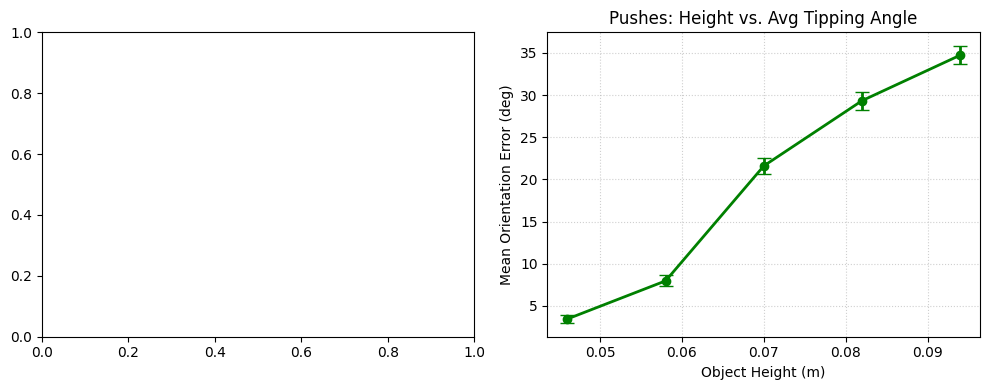

In [6]:
# Create bins for object height
pushes["height_bin"] = pd.cut(pushes["object_height"], bins=5)

# Calculate mean error and confidence interval for each bin
bin_stats = pushes.groupby("height_bin")["rot_error"].agg(["mean", "std", "count"]).reset_index()
# Calculate standard error for error bars
bin_stats["se"] = bin_stats["std"] / np.sqrt(bin_stats["count"])
bin_stats["height_mid"] = bin_stats["height_bin"].apply(lambda x: x.mid)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ... [Keep your Lift plot code here exactly as is] ...

# --- NEW PUSH PLOT (BINNED) ---
ax2.errorbar(bin_stats["height_mid"], bin_stats["mean"], yerr=bin_stats["se"] * 1.96, fmt="-o", color="green", capsize=5, linewidth=2)
ax2.set_title("Pushes: Height vs. Avg Tipping Angle")
ax2.set_xlabel("Object Height (m)")
ax2.set_ylabel("Mean Orientation Error (deg)")
ax2.grid(True, linestyle=":", alpha=0.6)

plt.tight_layout()
plt.savefig("physics_failure_modes_binned.pdf", transparent=True)
plt.show()